## Lasso / Ridge / ElasticNet / Unregularized Linear Regression on imdb movie reviews for rating prediction

In [73]:
import pickle
import os
ROOT_PATH = '../../'
data_path = os.path.join(ROOT_PATH,'data/processed/imdb/data.pickle')

with open(data_path,"rb") as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

In [74]:
print([el.shape for el in [X_train,X_test,y_train,y_test]])

[(10000, 51563), (25000, 51563), (10000,), (25000,)]


In [51]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.metrics import mean_squared_error

In [52]:
counter = 1
prev_mse = float('inf')
while True:
    lasso = Lasso(alpha=10**(-counter), max_iter=10000).fit(X_train, y_train)
    print(f"Alpha = 1e-{counter}")
    current_mse =  mean_squared_error(y_test, lasso.predict(X_test))
    print("Lasso MSE:", current_mse)
    print("Number of nonzero coefficients (Lasso):", (lasso.coef_ != 0).sum())
    if current_mse > prev_mse:
        break
    counter += 1
    prev_mse = current_mse


ols = LinearRegression().fit(X_train, y_train)
print("Unregularized MSE:", mean_squared_error(y_test, ols.predict(X_test)))

Alpha = 1e-1
Lasso MSE: 12.08246377
Number of nonzero coefficients (Lasso): 0
Alpha = 1e-2
Lasso MSE: 9.743527069449632
Number of nonzero coefficients (Lasso): 17
Alpha = 1e-3
Lasso MSE: 5.899147229882744
Number of nonzero coefficients (Lasso): 296
Alpha = 1e-4
Lasso MSE: 5.661323490910215
Number of nonzero coefficients (Lasso): 3905
Alpha = 1e-5
Lasso MSE: 8.748724246191662
Number of nonzero coefficients (Lasso): 9179
Unregularized MSE: 7.5934432784232255


In [53]:
from sklearn.model_selection import GridSearchCV
import numpy as np

alphas = np.concatenate([np.linspace(1e-5,1e-4,9),np.linspace(1e-4,1e-3,9)])
lasso = Lasso(max_iter=10000)
print(f"Searching for alphas: {alphas}")
grid = GridSearchCV(lasso, param_grid={'alpha': alphas}, cv=5, scoring='neg_mean_squared_error',verbose=2,n_jobs=-1)
grid.fit(X_train, y_train)
  
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Best alpha:", grid.best_params_['alpha'])
lasso_alpha = grid.best_params_['alpha']
print("Test MSE:", mse)

Searching for alphas: [1.000e-05 2.125e-05 3.250e-05 4.375e-05 5.500e-05 6.625e-05 7.750e-05
 8.875e-05 1.000e-04 1.000e-04 2.125e-04 3.250e-04 4.375e-04 5.500e-04
 6.625e-04 7.750e-04 8.875e-04 1.000e-03]
Fitting 5 folds for each of 18 candidates, totalling 90 fits


Best alpha: 0.00021250000000000002
Test MSE: 5.273286638392523


In [54]:
import numpy as np
import pandas as pd

results = grid.cv_results_
# print(results.keys())
alphas = results["param_alpha"].data.astype(float)
rmse = -results["mean_test_score"]   # convert neg RMSE → RMSE

df = pd.DataFrame({
    "alpha": alphas,
    "mse": rmse
}).sort_values("alpha")

print(df)

       alpha       mse
0   0.000010  8.107575
1   0.000021  7.383486
2   0.000033  6.883868
3   0.000044  6.512844
4   0.000055  6.239024
5   0.000066  6.019927
6   0.000077  5.837712
7   0.000089  5.691170
9   0.000100  5.577282
8   0.000100  5.577282
10  0.000213  5.179903
11  0.000325  5.227888
12  0.000438  5.353265
13  0.000550  5.480978
14  0.000663  5.600663
15  0.000775  5.707578
16  0.000888  5.807602
17  0.001000  5.902932


In [55]:
print("Best alpha:", grid.best_params_['alpha'])
print("Test MSE:", mse)

Best alpha: 0.00021250000000000002
Test MSE: 5.273286638392523


In [56]:
from sklearn.linear_model import Ridge

counter = 1
prev_mse = float('inf')
threshold = 1e-4
while True:
    model = Ridge(alpha=10**(-counter), max_iter=10000).fit(X_train, y_train)
    print(f"Alpha = 1e-{counter}")
    current_mse =  mean_squared_error(y_test, model.predict(X_test))
    print("Ridge MSE:", current_mse)
    print("Number of nonzero coefficients (Ridge) > 1e-4:", (model.coef_ > threshold).sum())
    if current_mse > prev_mse:
        break
    counter += 1
    prev_mse = current_mse


ols = LinearRegression().fit(X_train, y_train)
print("Unregularized MSE:", mean_squared_error(y_test, ols.predict(X_test)))


Alpha = 1e-1
Ridge MSE: 6.191892479150875
Number of nonzero coefficients (Ridge) > 1e-4: 25464
Alpha = 1e-2
Ridge MSE: 7.309180526552521
Number of nonzero coefficients (Ridge) > 1e-4: 25509
Unregularized MSE: 7.5934432784232255


In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import numpy as np

alphas = np.concatenate([np.linspace(1e-2,1e-1,9),np.linspace(1e-1,1,9)])
lasso = Pipeline([
    ("model",Ridge(max_iter=10000))
])
print(f"Searching for alphas: {alphas}")
grid = GridSearchCV(lasso, param_grid={'model__alpha': alphas}, cv=5, scoring='neg_mean_squared_error',verbose=2,n_jobs=-1)
grid.fit(X_train, y_train)
  
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Best alpha:", grid.best_params_['model__alpha'])
ridge_alpha = grid.best_params_['model__alpha']
print("Test MSE:", mse)

Searching for alphas: [0.01    0.02125 0.0325  0.04375 0.055   0.06625 0.0775  0.08875 0.1
 0.1     0.2125  0.325   0.4375  0.55    0.6625  0.775   0.8875  1.     ]
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best alpha: 0.8875
Test MSE: 5.146945768666516


In [58]:
import numpy as np
import pandas as pd

results = grid.cv_results_
# print(results.keys())
alphas = results["param_model__alpha"].data.astype(float)
rmse = -results["mean_test_score"]   # convert neg RMSE → RMSE

df = pd.DataFrame({
    "alpha": alphas,
    "mse": rmse
}).sort_values("alpha")

print(df)

      alpha       mse
0   0.01000  6.246990
1   0.02125  6.088887
2   0.03250  5.959888
3   0.04375  5.851591
4   0.05500  5.759234
5   0.06625  5.679648
6   0.07750  5.610247
7   0.08875  5.549009
9   0.10000  5.494426
8   0.10000  5.494426
10  0.21250  5.165179
11  0.32500  5.015485
12  0.43750  4.936371
13  0.55000  4.893361
14  0.66250  4.870757
15  0.77500  4.861063
16  0.88750  4.859819
17  1.00000  4.864810


In [59]:
from sklearn.linear_model import ElasticNetCV
param_grid = {
    "alpha": np.logspace(-4, 1, 10),     # regularization strength
    # "l1_ratio": np.linspace(0, 1, 5)    # interpolation between L2 and L1
}
NUM_SAMPLES = 1000
enet = ElasticNetCV(l1_ratio=0.5,alphas=param_grid['alpha'])
enet.fit(X_train[:NUM_SAMPLES], y_train[:NUM_SAMPLES])

print("Best alpha:", enet.alpha_)
enet_alpha = enet.alpha_
# print("Best l1 ratio:", enet.l1_ratio_)

Best alpha: 0.0001


In [60]:
from sklearn.linear_model import ElasticNetCV
param_grid = {
    "alpha": np.concatenate([np.linspace(1e-4,1e-3,10),np.linspace(1e-3, 1e-2, 10)])     # regularization strength
}
NUM_SAMPLES = 1000
enet = ElasticNetCV(l1_ratio=0.5,alphas=param_grid['alpha'])
enet.fit(X_train[:NUM_SAMPLES], y_train[:NUM_SAMPLES])

print("Best alpha:", enet.alpha_)
# print("Best l1 ratio:", enet.l1_ratio_)

Best alpha: 0.00019999999999999998


In [61]:
!notify-send "Finished running Jupyter Notebook for 533"

In [62]:
enet = ElasticNet(alpha=0.0008)
enet.fit(X_train,y_train)
enet.predict(X_test)

array([6.87753404, 4.89950962, 8.92825867, ..., 7.76496065, 7.06398185,
       4.56426893])

In [63]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
lasso = Lasso(alpha=lasso_alpha)
ridge = Ridge(alpha=ridge_alpha)
enet = ElasticNet(alpha=enet_alpha)
linearreg = LinearRegression()

models = [
    ("lasso", lasso),
    ("ridge", ridge),
    ("enet", enet),
    ("linear regression", linearreg)
]

results = []

for model_name, model in models:
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
    for s in scores:
        results.append({"model": model_name, "rmse": -s})



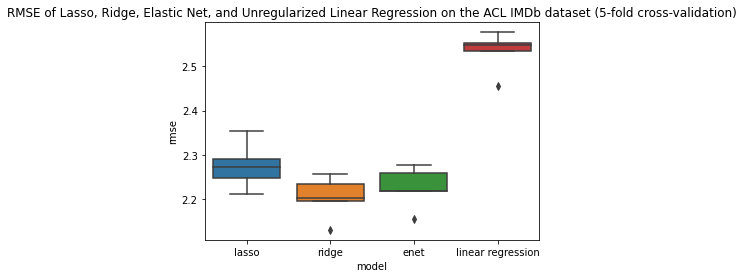

In [79]:
df = pd.DataFrame(results)

plt.title("RMSE of Lasso, Ridge, Elastic Net, and Unregularized Linear Regression on the ACL IMDb dataset (5-fold cross-validation)")
plt.xlabel("Model")
plt.ylabel("Root Mean Squared Error (RMSE)")
sns.boxplot(data=df, x="model", y="rmse")
plt.savefig("../../results/imdb/acl_imdb_cross_validation_score_models.png",dpi=300,bbox_inches='tight',facecolor='white')
plt.show()


In [65]:
print(df.groupby('model').mean())
print(df.groupby('model').std())


                       rmse
model                      
enet               2.225680
lasso              2.275442
linear regression  2.533487
ridge              2.204080
                       rmse
model                      
enet               0.047162
lasso              0.053249
linear regression  0.046612
ridge              0.048074


In [66]:
def evaluate_binary_classification(model):
    y_pred_binary = model.predict(X_test) > 5
    y_test_binary = y_test > 5
    return np.sum(y_pred_binary == y_test_binary) / y_pred_binary.shape[0]

In [67]:


lasso = Lasso(alpha=lasso_alpha)
lasso.fit(X_train,y_train)
print(f"Number of non-zero covariates used by Lasso: {np.sum(lasso.coef_ != 0)}")

Number of non-zero covariates used by Lasso: 1870


In [68]:
ridge = Ridge(alpha=ridge_alpha)
ridge.fit(X_train,y_train)
threshold = 1e-5
print(f"Number of covariates > epsilon (epsilon = 1e-5) used by Ridge: {np.sum(ridge.coef_ > threshold)}")

Number of covariates > epsilon (epsilon = 1e-5) used by Ridge: 25538


In [69]:
enet = ElasticNet(alpha=enet_alpha)
enet.fit(X_train,y_train)
threshold = 1e-5
print(f"Number of covariates > epsilon (epsilon = 1e-5) used by ElasticNet: {np.sum(enet.coef_ > threshold)}")

Number of covariates > epsilon (epsilon = 1e-5) used by ElasticNet: 5379


In [ ]:
linear_reg = LinearRegression()
linear_reg.fit(X_train,y_train)

LinearRegression()

In [78]:
for model_name, model in [
    ("lasso", lasso),
    ("ridge", ridge),
    ("enet", enet),
    ("linear regression",linear_reg)
]:
    accuracy = evaluate_binary_classification(model)
    rmse = mean_squared_error(model.predict(X_test),y_test) ** 0.5
    print(f"{model_name}: {accuracy*100:.3f}%, RMSE {rmse:.4f}") 


lasso: 84.640%, RMSE 2.2936
ridge: 85.448%, RMSE 2.2632
enet: 85.328%, RMSE 2.2701
linear regression: 78.836%, RMSE 2.7407


In [72]:
X_train.shape

(10000, 51563)